In [1]:
import sys
sys.path.append("..") if ".." not in sys.path else print("Already exists")

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision import models
from torchvision import transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from utils.dataset import get_dataloader
from utils.training import TrainingInterface, print_total_params, train_network
from utils.plots import EvaluationPlots

### Initiate Dataloaders

In [2]:
further_transforms = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ]
)

BATCH_SIZE = 32
WORKERS = 12

In [3]:
dataloader_train = get_dataloader(
    root_dir="../data/interim_train/",
    df=pd.read_csv("../data/train.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=further_transforms,
    batch_size=BATCH_SIZE,
    workers=WORKERS,
    pin_memory=True,
    shuffle=True
)
dataloader_val = get_dataloader(
    root_dir="../data/val/",
    df=pd.read_csv("../data/val.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=further_transforms,
    batch_size=BATCH_SIZE,
    workers=12,
    pin_memory=True,
    shuffle=True
)
dataloader_test = get_dataloader(
    root_dir="../data/test/",
    df=pd.read_csv("../data/test.csv"),
    fp_label_translator='../utils/dataset/label_translate.pkl',
    transformations=further_transforms,
    batch_size=BATCH_SIZE,
    workers=WORKERS,
    pin_memory=True,
    shuffle=True
)

In [4]:
assert dataloader_train.dataset.label_dict == dataloader_val.dataset.label_dict
assert dataloader_val.dataset.label_dict == dataloader_test.dataset.label_dict

### Check Dataloader Batch

In [5]:
# Plot batch
check_batch = False

plt.rcParams["savefig.bbox"] = "tight"

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 20))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


if check_batch:
    for loader in [dataloader_train, dataloader_val, dataloader_test]:
        img, labels = next(iter(loader))
        assert img.shape[0] == BATCH_SIZE
        assert len(labels) == BATCH_SIZE

# ConvNext

## Transfer-Learning

In [58]:
convnext_tiny_ = models.convnext_tiny(pretrained=True, progress=True)

In [59]:
#print(convnext_tiny_)

In [60]:
for param in convnext_tiny_.parameters():
    param.requires_grad = False

convnext_tiny_.classifier[2] = nn.Linear(
    in_features=768, out_features=len(dataloader_train.dataset.label_dict.keys())
)

for param in convnext_tiny_.classifier.parameters():
    param.requires_grad = False
    print(param.requires_grad)

# Set requires grad for FC weights
convnext_tiny_.classifier[2].weight.requires_grad = True
convnext_tiny_.classifier[2].bias.requires_grad = True

False
False
False
False


In [61]:
# Check
for name, param in convnext_tiny_.named_parameters():
    if param.requires_grad:
        print(name)

classifier.2.weight
classifier.2.bias


In [62]:
convnext = TrainingInterface(model=convnext_tiny_, name="convnext_tiny", history=True)

Found Existing History Folder. Removing all Files: train_history_convnext_tiny


In [63]:
convnext.print_total_params()

convnext_tiny | Trainable Parameters: 27830125


In [64]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext.model.parameters(), lr=0.0003)

In [65]:
convnext.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=40,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

  0%|          | 0/7920 [00:00<?, ?it/s]

Epoch 1/40: [Train-Loss = 342.033] || [Validation-Loss = 12.359]
Epoch 2/40: [Train-Loss = 231.07] || [Validation-Loss = 10.842]
Epoch 3/40: [Train-Loss = 197.57] || [Validation-Loss = 10.379]
Epoch 4/40: [Train-Loss = 178.328] || [Validation-Loss = 10.091]
Epoch 5/40: [Train-Loss = 164.853] || [Validation-Loss = 9.438]
Epoch 6/40: [Train-Loss = 155.886] || [Validation-Loss = 9.35]
Epoch 7/40: [Train-Loss = 147.409] || [Validation-Loss = 9.266]
Epoch 8/40: [Train-Loss = 143.491] || [Validation-Loss = 9.136]
Epoch 9/40: [Train-Loss = 138.086] || [Validation-Loss = 8.782]
Epoch 10/40: [Train-Loss = 133.629] || [Validation-Loss = 8.834]
Epoch 11/40: [Train-Loss = 129.587] || [Validation-Loss = 9.034]
Epoch 12/40: [Train-Loss = 125.553] || [Validation-Loss = 8.73]
Epoch 13/40: [Train-Loss = 121.018] || [Validation-Loss = 8.715]
Epoch 14/40: [Train-Loss = 119.022] || [Validation-Loss = 8.685]
Epoch 15/40: [Train-Loss = 116.359] || [Validation-Loss = 8.55]
Epoch 16/40: [Train-Loss = 113.116]

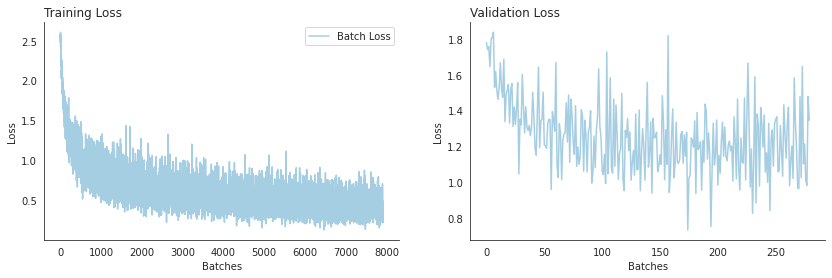

In [66]:
EvaluationPlots.plot_train_val_loss(convnext.train_loss, 
                                    convnext.val_loss)

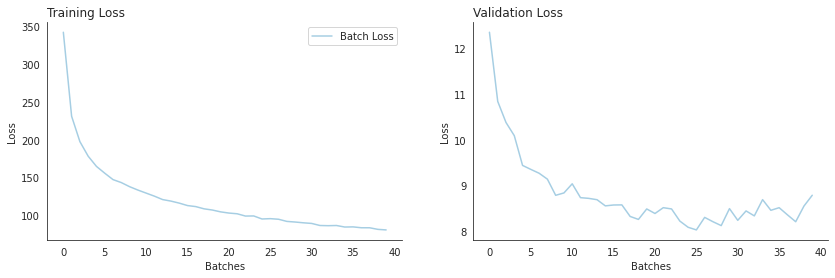

In [72]:
EvaluationPlots.plot_train_val_loss(train_loss=convnext.train_epoch_loss, 
                                    val_loss=convnext.val_epoch_loss)

In [79]:
convnext.load_from_history(epoch=25, inplace=True)

Replaced self.model with model from epoch 25


In [80]:
metrics = convnext.calculate_metrics(dataloader_train=dataloader_train, 
                                     dataloader_test=dataloader_test, 
                                     metric_funcs=[precision_score, recall_score, f1_score], 
                                     average='macro')

Get Predictions on Trainset:   0%|          | 0/198 [00:00<?, ?it/s]

Get Predictins on Testset:   0%|          | 0/7 [00:00<?, ?it/s]

In [81]:
metrics

{'train': {'precision_score': 0.8810113130762057,
  'recall_score': 0.8773985005466114,
  'f1_score': 0.8778944347986286},
 'test': {'precision_score': 0.621665267766038,
  'recall_score': 0.6030086019666873,
  'f1_score': 0.5322444162155169}}

In [84]:
res = convnext.predict(dataloader_test, return_images = False, return_prob = False)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

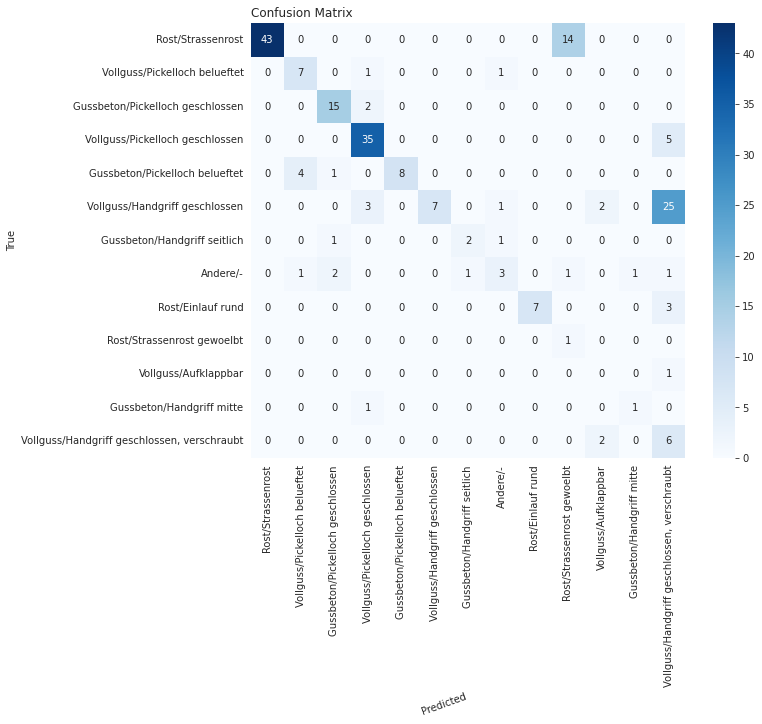

In [86]:
EvaluationPlots.plot_confusion_matrix(res[0], res[1], dataloader_test.dataset.label_dict_r)

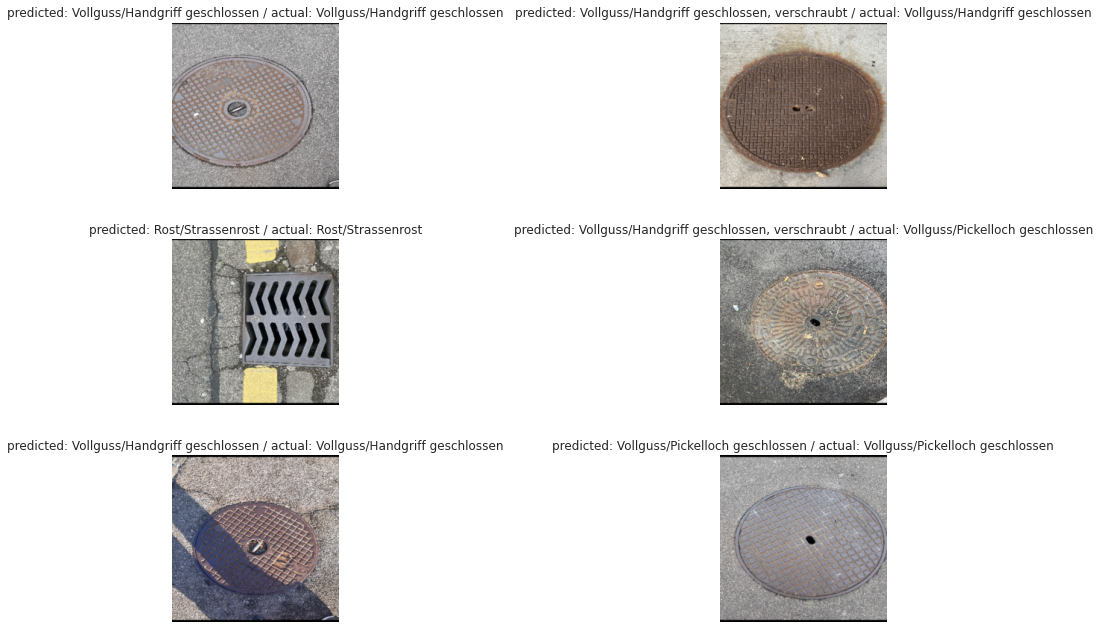

In [87]:
EvaluationPlots.visualize_model(model=convnext.model, 
                                dataloader=dataloader_test, 
                                label_translator=dataloader_test.dataset.label_dict_r)

## No Transfer-Learning

In [6]:
convnext_tiny_ = models.convnext_tiny(pretrained=False, progress=True)

In [7]:
for param in convnext_tiny_.parameters():
    param.requires_grad = True

In [8]:
convnext = TrainingInterface(model=convnext_tiny_, 
                             name='convnext_tiney_npre', 
                             history=True) 

Found Existing History Folder. Removing all Files: train_history_convnext_tiney_npre


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convnext.model.parameters(), lr=0.0001)

In [ ]:
convnext.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=40,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)

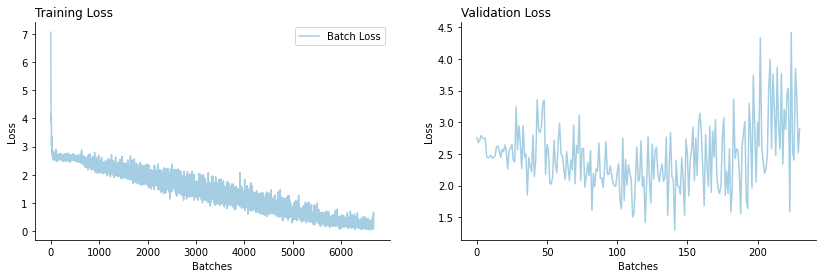

In [11]:
EvaluationPlots.plot_train_val_loss(convnext.train_loss, 
                                    convnext.val_loss,)

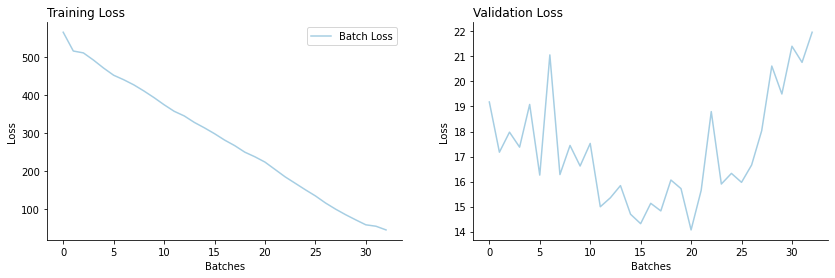

In [12]:
EvaluationPlots.plot_train_val_loss(train_loss=convnext.train_epoch_loss, 
                                    val_loss=convnext.val_epoch_loss)

In [13]:
convnext.load_from_history(epoch=20, inplace=True)

Replaced self.model -> epoch 20


In [14]:
metrics = convnext.calculate_metrics(dataloader_train=dataloader_train, 
                                     dataloader_test=dataloader_test, 
                                     metric_funcs=[precision_score, recall_score, f1_score], 
                                     average='macro')

Predictions Train-Set:   0%|          | 0/198 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/7 [00:00<?, ?it/s]

In [81]:
metrics

{'train': {'precision_score': 0.8810113130762057,
  'recall_score': 0.8773985005466114,
  'f1_score': 0.8778944347986286},
 'test': {'precision_score': 0.621665267766038,
  'recall_score': 0.6030086019666873,
  'f1_score': 0.5322444162155169}}

In [84]:
res = convnext.predict(dataloader_test, return_images = False, return_prob = False)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

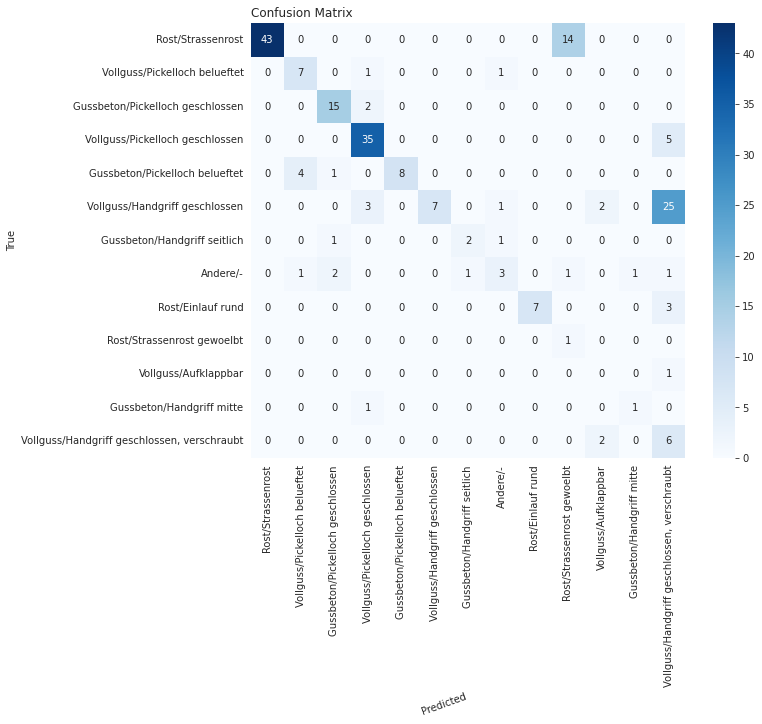

In [86]:
EvaluationPlots.plot_confusion_matrix(res[0], res[1], dataloader_test.dataset.label_dict_r)

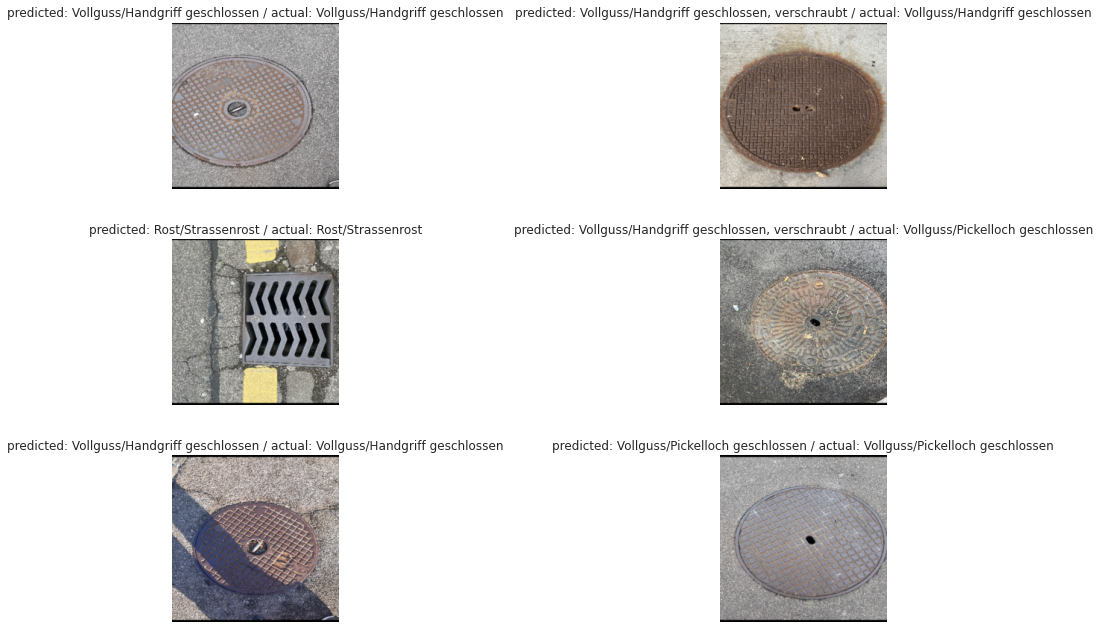

In [87]:
EvaluationPlots.visualize_model(model=convnext.model, 
                                dataloader=dataloader_test, 
                                label_translator=dataloader_test.dataset.label_dict_r)

## ResNet18

### Pretrained

In [37]:
resnet_ = models.resnet18(pretrained=True, progress=True)

In [38]:
#print(resnet_)

In [39]:
for param in resnet_.parameters():
    param.requires_grad = False

# Replace fc
resnet_.fc = nn.Linear(512, len(dataloader_train.dataset.label_dict.keys()))

# Enable grad
resnet_.fc.weight.requires_grad = True
resnet_.fc.bias.requires_grad = True

# check
for name, param in resnet_.named_parameters():
    if param.requires_grad:
        print('Requires Grad:', name)

Requires Grad: fc.weight
Requires Grad: fc.bias


In [40]:
resnet = TrainingInterface(model=resnet_, name='resnet18_pretrained', history=True)

Found Existing History Folder. Removing all Files: train_history_resnet18_pretrained


In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.model.parameters(), lr=.00001)

  0%|          | 0/3960 [00:00<?, ?it/s]

Epoch 1/20: [Train-Loss = 290.897] || [Validation-Loss = 13.13]
Epoch 2/20: [Train-Loss = 288.355] || [Validation-Loss = 13.026]
Epoch 3/20: [Train-Loss = 285.796] || [Validation-Loss = 12.946]
Epoch 4/20: [Train-Loss = 283.052] || [Validation-Loss = 13.068]
Epoch 5/20: [Train-Loss = 280.763] || [Validation-Loss = 12.814]
Epoch 6/20: [Train-Loss = 279.1] || [Validation-Loss = 12.906]
Epoch 7/20: [Train-Loss = 276.449] || [Validation-Loss = 12.761]
Epoch 8/20: [Train-Loss = 274.006] || [Validation-Loss = 12.959]
Epoch 9/20: [Train-Loss = 271.656] || [Validation-Loss = 12.943]
Epoch 10/20: [Train-Loss = 270.427] || [Validation-Loss = 12.765]
Epoch 11/20: [Train-Loss = 267.943] || [Validation-Loss = 12.943]
Epoch 12/20: [Train-Loss = 266.766] || [Validation-Loss = 12.741]
Epoch 13/20: [Train-Loss = 264.391] || [Validation-Loss = 12.682]
Epoch 14/20: [Train-Loss = 263.406] || [Validation-Loss = 12.601]
Epoch 15/20: [Train-Loss = 261.665] || [Validation-Loss = 12.446]
Epoch 16/20: [Train-Lo

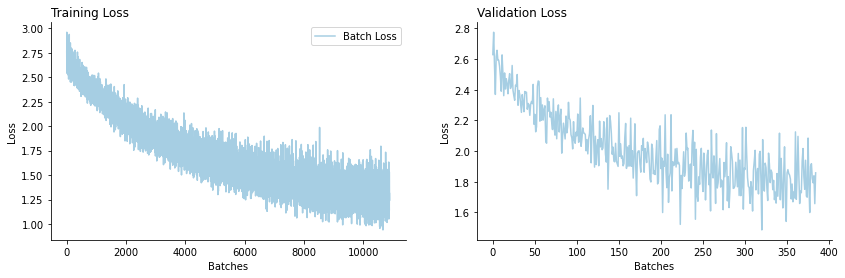

In [43]:
resnet.train(
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=20,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    verbose=True
)
EvaluationPlots.plot_train_val_loss(resnet.train_loss, resnet.val_loss)

In [ ]:
EvaluationPlots.plot_train_val_loss(train_loss=resnet.train_epoch_loss, 
                                    val_loss=resnet.val_epoch_loss)

In [ ]:
resnet.load_from_history(epoch=20, inplace=True)

In [14]:
metrics = resnet.calculate_metrics(dataloader_train=dataloader_train, 
                                     dataloader_test=dataloader_test, 
                                     metric_funcs=[precision_score, recall_score, f1_score], 
                                     average='macro')

Predictions Train-Set:   0%|          | 0/198 [00:00<?, ?it/s]

Predictions Test-Set:   0%|          | 0/7 [00:00<?, ?it/s]

In [81]:
metrics

{'train': {'precision_score': 0.8810113130762057,
  'recall_score': 0.8773985005466114,
  'f1_score': 0.8778944347986286},
 'test': {'precision_score': 0.621665267766038,
  'recall_score': 0.6030086019666873,
  'f1_score': 0.5322444162155169}}

In [84]:
res = resnet.predict(dataloader_test, return_images = False, return_prob = False)

Calculate Predictions:   0%|          | 0/7 [00:00<?, ?it/s]

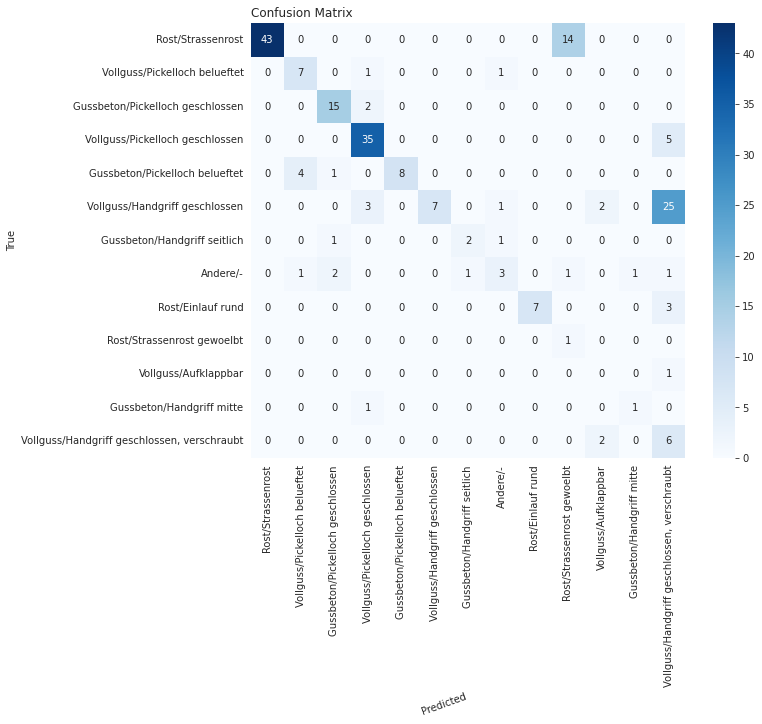

In [86]:
EvaluationPlots.plot_confusion_matrix(res[0], res[1], dataloader_test.dataset.label_dict_r)

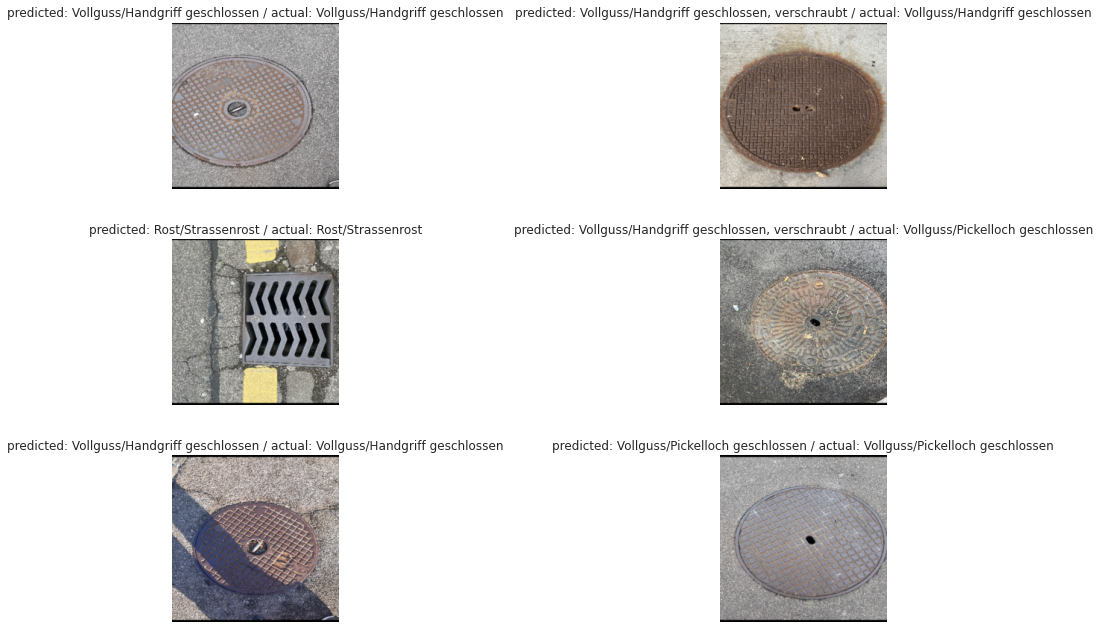

In [87]:
EvaluationPlots.visualize_model(model=resnet.model, 
                                dataloader=dataloader_test, 
                                label_translator=dataloader_test.dataset.label_dict_r)